# Control of a "spacecraft" platform with a reaction wheel

Do all imports:

In [1]:
# These are standard modules
import time
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown

# This is a custom interface to the pybullet simulator
import ae353_platform

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Oct 20 2025 09:40:06


## Theory

### Derive state-space model

Define the equations of motion.

In [2]:
# Define variables
q1, v1, v2, tau = sym.symbols('q1, v1, v2, tau')

# Define parameters
J1, J2, m, g, l = sym.symbols('J1, J2, m, g, l')

# Define right-hand side of ODEs
f = sym.Matrix([
    v1,
    (1 / J1) * (tau - m * g * l * sym.sin(q1)),
    (1 / J2) * (- ((J1 + J2) / J1) * tau + (J2 / J1) * m * g * l * sym.sin(q1))
])

Choose equilibrium point.

In [3]:
q1e = sym.pi
v1e = 0
v2e = 5 * sym.pi / 3
taue = 0

eq = {
    q1: q1e,
    v1: v1e,
    v2: v2e,
    tau: taue,
}

Verify equilibrium point (should produce all zeros).

In [4]:
f.subs(eq)

Matrix([
[0],
[0],
[0]])

Linearize about equilibrium point.

In [5]:
A = f.jacobian([q1, v1, v2]).subs(eq)
B = f.jacobian([tau]).subs(eq)

Show result.

In [6]:
A

Matrix([
[        0, 1, 0],
[ g*l*m/J1, 0, 0],
[-g*l*m/J1, 0, 0]])

In [7]:
B

Matrix([
[                 0],
[              1/J1],
[-(J1 + J2)/(J1*J2)]])

### Design linear state feedback

Choose peak time and peak overshoot.

In [8]:
Mp = 1 / sym.exp(sym.pi / 2)
Tp = sym.pi / 4

Choose eigenvalue locations to achieve peak time and peak overshoot (approximately).

In [9]:
# Place dominant eigenvalues to achieve specifications
sigma = -sym.ln(Mp) / Tp
omega = sym.pi / Tp
s1 = -sigma + omega * sym.I
s2 = -sigma - omega * sym.I

# Place third eigenvalue to have little effect on closed-loop response
s3 = -5 * sigma

Find and show coefficients of characteristic polynomial we want.

In [10]:
# Define variable in polynomial
s = sym.symbols('s')

# Find coefficients
c_want = sym.simplify(sym.Poly((s - s1) * (s - s2) * (s - s3))).coeffs()

# Show coefficients
c_want

[1, 14, 60, 200]

Find and show coefficients of characteristic polynomial we have.

In [11]:
# Define gain matrix in terms of symbolic variables
k1, k2, k3 = sym.symbols('k1, k2, k3')
K = sym.Matrix([[k1, k2, k3]])

# Find coefficients
c_have = sym.simplify((A - B @ K).charpoly()).coeffs()

# Show coefficients
c_have

[1, (-J1*k3 + J2*k2 - J2*k3)/(J1*J2), (-g*l*m + k1)/J1, g*k3*l*m/(J1*J2)]

Equate coefficients and solve for gains.

In [12]:
# Solve
sol = sym.simplify(sym.solve(sym.Matrix(c_want) - sym.Matrix(c_have), [k1, k2, k3]))

# Plug into gain matrix
K = K.subs(sol)

# Show gain matrix
K

Matrix([[60*J1 + g*l*m, (200*J1**2 + 200*J1*J2 + 14*J1*g*l*m)/(g*l*m), 200*J1*J2/(g*l*m)]])

## Implementation

Convert equilibrium point from symbolic to numeric.

In [13]:
q1e = float(q1e)
v1e = float(v1e)
v2e = float(v2e)
taue = float(taue)

Define lambda functions that will allow us to convert $A$, $B$, and $K$ from symbolic to numeric.

In [14]:
A_num = sym.lambdify([J1, J2, m, g, l], A)
B_num = sym.lambdify([J1, J2, m, g, l], B)
K_num = sym.lambdify([J1, J2, m, g, l], K)

Define parameter values.

In [15]:
# distance from platform axis to wheel axis
l = 1.

# radius of wheel
rw = 0.5

# mass of wheel
mw = 0.25

# moi of wheel
Jw = 0.5 * mw * rw**2

# mass of platform
mp = 12. * (1. - mw * l**2) / (3.**2 + 2.**2)

# moment of inertia of platform
Jp = (1. / 12.) * mp * (3.**2 + 2.**2)

# gravity
g = 9.81

# composite parameters
J1 = Jp + mw * l**2
J2 = Jw
m = mw

Do the conversion and show the result.

In [16]:
A = A_num(J1, J2, m, g, l).astype(float)
B = B_num(J1, J2, m, g, l).astype(float)
K = K_num(J1, J2, m, g, l).astype(float)

print(f'A =\n{A}\n')
print(f'B =\n{B}\n')
print(f'K =\n{K}\n')

A =
[[ 0.      1.      0.    ]
 [ 2.4525  0.      0.    ]
 [-2.4525  0.      0.    ]]

B =
[[  0.]
 [  1.]
 [-33.]]

K =
[[62.4525     98.09785933  2.54841998]]



Define functions for implementation and analysis.

In [17]:
# Define a controller that implements linear state feedback.
class Controller:
    def __init__(self, K, q1e, v1e, v2e, taue):
        self.K = K
        self.q1e = q1e
        self.v1e = v1e
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Find state
        x = np.array([
            platform_angle - self.q1e,
            platform_velocity - self.v1e,
            wheel_velocity - self.v2e,
        ])
        
        # Find input
        u = - self.K @ x
        
        # Find actuator command
        tau = u[0]
        
        wheel_torque = -tau
        return wheel_torque
    
# Define a function to get data from simulation for a given choice
# of equilibrium point, gain matrix, and initial condition.
def get_data(simulator, q1e, v1e, v2e, taue, K, q1i, v1i, v2i, max_time=5.0):
    # Create controller
    controller = Controller(K, q1e, v1e, v2e, taue)
    
    # Reset simulator
    simulator.reset(
        platform_angle=q1i,
        platform_velocity=v1i,
        wheel_angle=0.,
        wheel_velocity=v2i,
    )

    # Reset controller
    controller.reset()

    # Run simulator
    data = simulator.run(
        controller,
        max_time=max_time,
    )
    
    # Return data
    return data

# Define a function to find numeric solution to closed-loop (linear) system.
def get_x_numeric(data, q1e, v1e, v2e, A, B):
    # Define initial conditions
    x0 = np.array([
        data['platform_angle'][0] - q1e,
        data['platform_velocity'][0] - v1e,
        data['wheel_velocity'][0] - v2e,
    ])

    # Create empty array to hold state at each time
    x = []

    # Compute state at each time
    for t in data['t']:
        x.append(linalg.expm((A - B @ K) * t) @ x0)
    x = np.array(x)
    
    # Return state at each time
    return x
    
# Define a function to show results.
def show_results(
            data,
            q1e, v1e, v2e, taue,
            A, B, K,
            q1i, v1i, v2i,
            show_pred=False,
            filename=None,
            fontsize=16,
        ):
    t = data['t']
    q1 = data['platform_angle']
    v1 = data['platform_velocity']
    v2 = data['wheel_velocity']
    tau = - data['wheel_torque']
    x1 = q1 - q1e
    x2 = v1 - v1e
    x3 = v2 - v2e
    
    fig, (ax_q1, ax_v1, ax_v2, ax_tau) = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

    ax_q1.plot(t, q1, label='$q_1$', linewidth=2)
    ax_q1.plot(t, np.ones_like(t) * q1e, '--', label=r'$q_{1e}$', linewidth=2)
    
    ax_v1.plot(t, v1, label='$v_1$', linewidth=2)
    ax_v1.plot(t, np.ones_like(t) * v1e, '--', label=r'$v_{1e}$', linewidth=2)
    
    ax_v2.plot(t, v2, label='$v_2$', linewidth=2)
    ax_v2.plot(t, np.ones_like(t) * v2e, '--', label=r'$v_{2e}$', linewidth=2)
    
    ax_tau.plot(t, tau, label=r'$\tau$', linewidth=2)
    ax_tau.plot(t, np.ones_like(t) * taue, '--', label=r'$\tau_{e}$', linewidth=2)
    ax_tau.plot(t, simulator.tau_max * np.ones_like(t), '--', linewidth=2, color='C2')
    ax_tau.plot(t, - simulator.tau_max * np.ones_like(t), '--', linewidth=2, color='C2')
    
    if show_pred:
        # Get x(t) and extract components
        x_num = get_x_numeric(data, q1e, v1e, v2e, A, B)
        x1_num = x_num[:, 0]
        x2_num = x_num[:, 1]
        x3_num = x_num[:, 2]
        
        # Get u(t)
        u_num = - (K @ x_num.T).T
        u1_num = u_num[:, 0]
        
        # Compute q1(t), v1(t), and v2(t) from x(t)
        q1_num = x1_num + q1e
        v1_num = x2_num + v1e
        v2_num = x3_num + v2e
        
        # Compute tau(t) from u(t)
        tau_num = u1_num + taue
        
        # Add everything to plots
        ax_q1.plot(t, q1_num, ':', label='$q_1$ (from linear model)', linewidth=4, color='C3')
        ax_v1.plot(t, v1_num, ':', label='$v_1$ (from linear model)', linewidth=4, color='C3')
        ax_v2.plot(t, v2_num, ':', label='$v_2$ (from linear model)', linewidth=4, color='C3')
        ax_tau.plot(t, tau_num, ':', label=r'$\tau$ (from linear model)', linewidth=4, color='C3')
        
    ax_q1.grid()
    ax_q1.legend(fontsize=fontsize, ncol=3, loc='upper right')
    ax_q1.tick_params(labelsize=fontsize)
    ax_q1.set_ylim(q1e - 0.5, q1e + 0.5)
    ax_q1.set_ylabel('angle (rad)', fontsize=14)
    
    ax_v1.grid()
    ax_v1.legend(fontsize=fontsize, ncol=3, loc='upper right')
    ax_v1.tick_params(labelsize=fontsize)
    ax_v1.set_ylim(v1e - 1, v1e + 1)
    ax_v1.set_ylabel('angular velocity (rad/s)', fontsize=14)
    
    ax_v2.grid()
    ax_v2.legend(fontsize=fontsize, ncol=3, loc='upper right')
    ax_v2.tick_params(labelsize=fontsize)
    ax_v2.set_ylim(v2e - 20, v2e + 20)
    ax_v2.set_ylabel('angular velocity (rad/s)', fontsize=14)

    ax_tau.grid()
    ax_tau.legend(fontsize=fontsize, ncol=3, loc='upper right')
    ax_tau.tick_params(labelsize=fontsize)
    ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)
    ax_tau.set_ylabel('torque (N-m)', fontsize=14)
        
    ax_tau.set_xlabel('time (s)', fontsize=fontsize)
    ax_tau.set_xlim([data['t'][0], data['t'][-1]])
    
    fig.tight_layout()
    if filename is not None:
        fig.savefig(filename)
    
    plt.show()

Create an instance of the simulator with no display.

In [18]:
simulator = ae353_platform.Simulator(
    display=False,
    roll=(np.pi / 2),
)

argv[0]=


Save a snapshot of the simulation window to include in the report.

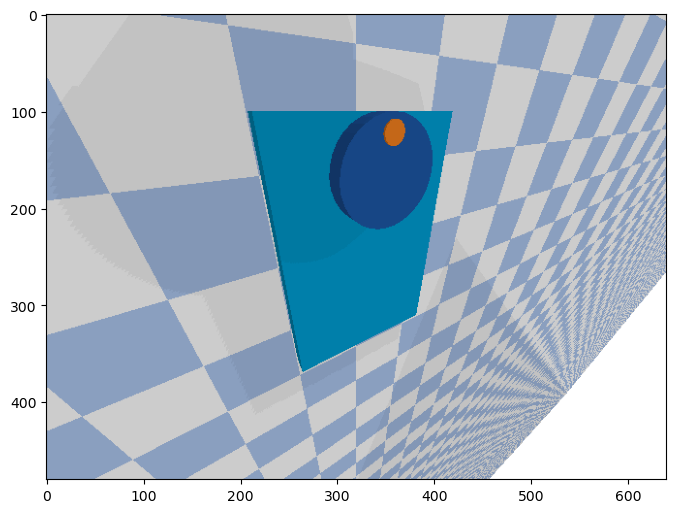

In [19]:
# Reset simulator to equilibrium
simulator.reset(
    platform_angle=q1e,
    platform_velocity=v1e,
    wheel_angle=0.,
    wheel_velocity=v2e,
)

# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('fig00.pdf', rgba)

Show example results for small error in initial platform angle.

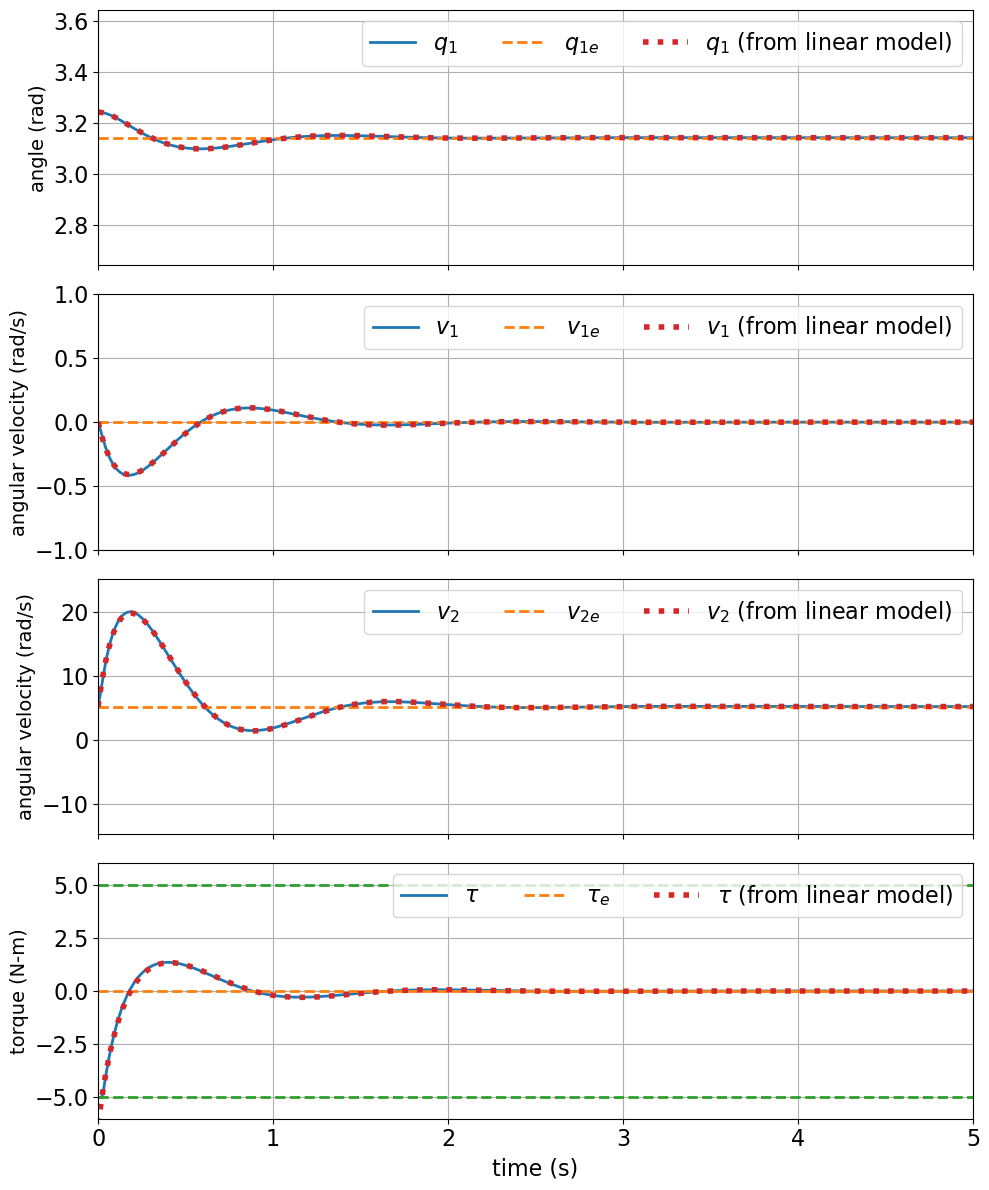

In [20]:
(q1i, v1i, v2i) = (q1e + 0.1, v1e + 0.0, v2e + 0.0)
data = get_data(simulator, q1e, v1e, v2e, taue, K, q1i, v1i, v2i, max_time=5.0)
show_results(
    data,
    q1e, v1e, v2e, taue,
    A, B, K,
    q1i, v1i, v2i,
    show_pred=True,
    filename='fig01.pdf',
)

Compute peak time and peak overshoot for this example.

In [21]:
# Get index of peak (in this case, the index at which the
# platform is at its minimum - not true in general!)
i_peak = np.argmin(data['platform_angle'])

# Get peak time
Tp = data['t'][i_peak]

# Get peak overshoot
Mp = np.abs((data['platform_angle'][i_peak] - q1e) / (q1i - q1e))

# Show peak time and peak overshoot
print(f'Tp = {Tp:.2f}')
print(f'Mp = {Mp:.2f}')

Tp = 0.58
Mp = 0.44


Show example results for large error in initial platform angle.

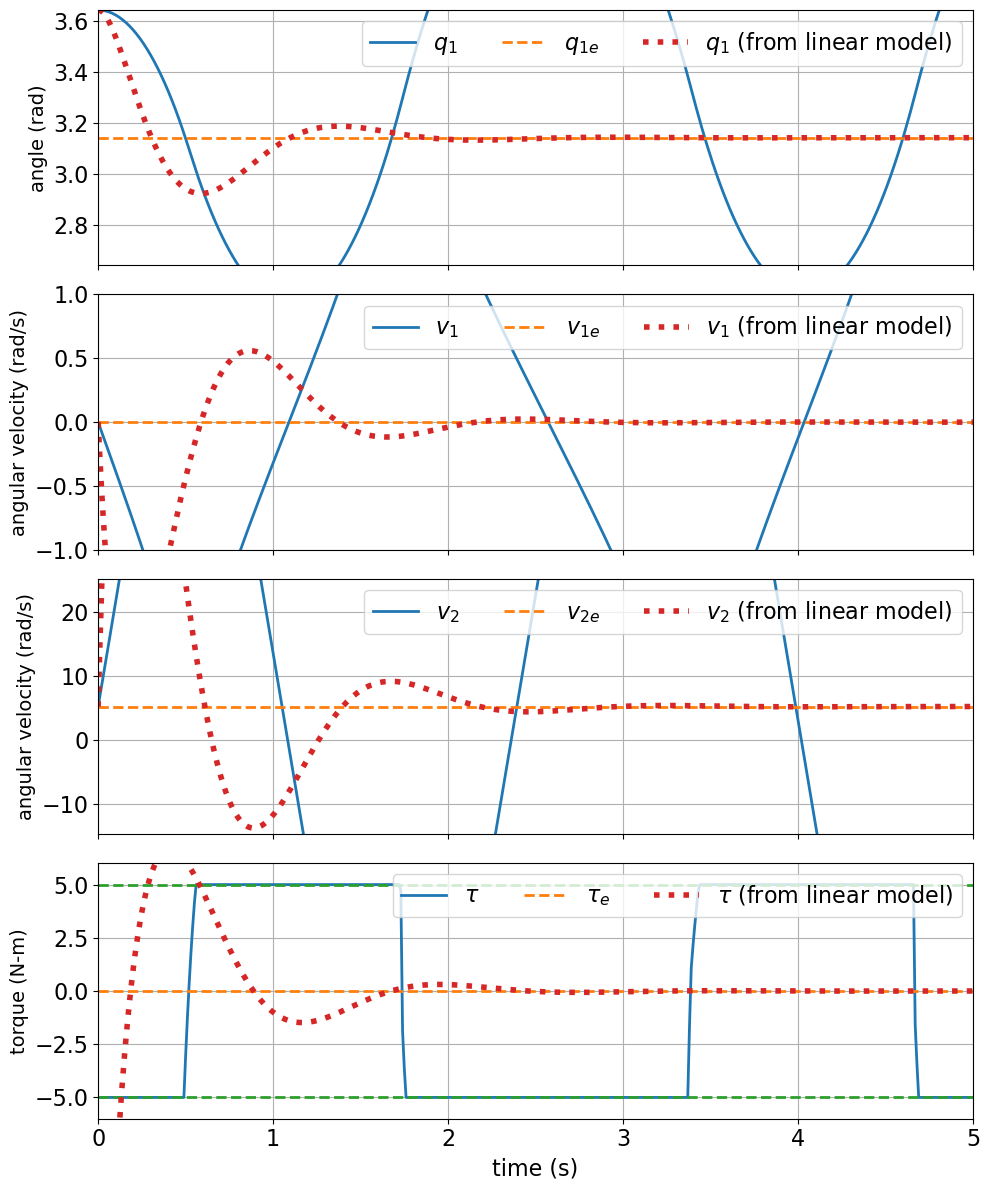

In [22]:
(q1i, v1i, v2i) = (q1e + 0.5, v1e + 0.0, v2e + 0.0)
data = get_data(simulator, q1e, v1e, v2e, taue, K, q1i, v1i, v2i, max_time=5.0)
show_results(
    data,
    q1e, v1e, v2e, taue,
    A, B, K,
    q1i, v1i, v2i,
    show_pred=True,
    filename='fig02.pdf',
)

Find set of initial conditions for which system converges in at most four seconds.

In [23]:
# Define a function to check of all states converge within four seconds
def is_stable_in_simulation(data, q1e, v1e, v2e, taue):
    # Get last second of data
    t = data['t'][-100:]
    q1 = data['platform_angle'][-100:]
    v1 = data['platform_velocity'][-100:]
    v2 = data['wheel_velocity'][-100:]
    
    # Check if x(t) is near zero throughout this last second
    q1_converged = np.allclose(q1 - q1e, 0., rtol=1e-2, atol=1e-2)
    v1_converged = np.allclose(v1 - v1e, 0., rtol=1e-2, atol=1e-2)
    v2_converged = np.allclose(v2 - v2e, 0., rtol=1e-2, atol=1e-2)
    return q1_converged and v1_converged and v2_converged

# Always start v2 at equilibrium value
v2i = v2e

# Create lists to hold results
q1_bnd = []
v1_bnd = []

# Search for the largest initial error in a particular direction
# (in the space of q1, v1) that results in closed-loop stability
d_step = 0.01
for a in np.linspace(0, 2 * np.pi, 100):
    d = d_step
    while True:
        q1i = q1e + (d * np.cos(a))
        v1i = v1e + (d * np.sin(a))
        data = get_data(simulator, q1e, v1e, v2e, taue, K, q1i, v1i, v2i)
        if not is_stable_in_simulation(data, q1e, v1e, v2e, taue):
            q1_bnd.append(q1i - q1e)
            v1_bnd.append(v1i - v1e)
            print(f' {a:.2f} : ({(q1i - q1e):.2f}, {(v1i - v1e):.2f})')
            break
        d += d_step

 0.00 : (0.15, 0.00)
 0.06 : (0.14, 0.01)
 0.13 : (0.13, 0.02)
 0.19 : (0.12, 0.02)
 0.25 : (0.11, 0.03)
 0.32 : (0.10, 0.03)
 0.38 : (0.09, 0.04)
 0.44 : (0.08, 0.04)
 0.51 : (0.08, 0.04)
 0.57 : (0.08, 0.05)
 0.63 : (0.06, 0.05)
 0.70 : (0.06, 0.05)
 0.76 : (0.06, 0.06)
 0.83 : (0.05, 0.06)
 0.89 : (0.05, 0.06)
 0.95 : (0.05, 0.07)
 1.02 : (0.04, 0.07)
 1.08 : (0.04, 0.07)
 1.14 : (0.03, 0.07)
 1.21 : (0.03, 0.07)
 1.27 : (0.02, 0.08)
 1.33 : (0.02, 0.08)
 1.40 : (0.01, 0.08)
 1.46 : (0.01, 0.08)
 1.52 : (0.00, 0.09)
 1.59 : (-0.00, 0.09)
 1.65 : (-0.01, 0.09)
 1.71 : (-0.01, 0.10)
 1.78 : (-0.02, 0.10)
 1.84 : (-0.03, 0.11)
 1.90 : (-0.04, 0.11)
 1.97 : (-0.05, 0.11)
 2.03 : (-0.06, 0.13)
 2.09 : (-0.08, 0.13)
 2.16 : (-0.09, 0.14)
 2.22 : (-0.12, 0.15)
 2.28 : (-0.14, 0.17)
 2.35 : (-0.19, 0.19)
 2.41 : (-0.25, 0.23)
 2.48 : (-0.36, 0.28)
 2.54 : (-0.40, 0.28)
 2.60 : (-0.39, 0.24)
 2.67 : (-0.37, 0.19)
 2.73 : (-0.33, 0.14)
 2.79 : (-0.28, 0.10)
 2.86 : (-0.25, 0.07)
 2.92 : (-0.2

Plot set of initial conditions for which all states converge within four seconds.

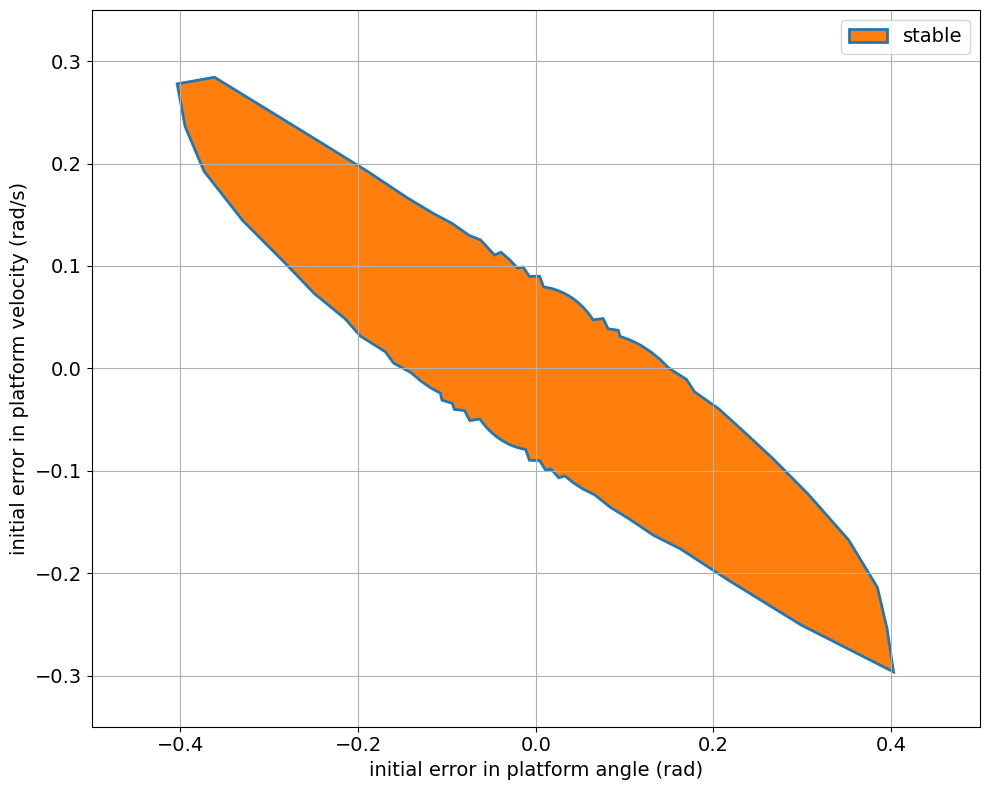

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
ax.fill(
    q1_bnd,
    v1_bnd,
    linestyle='-',
    linewidth=2,
    edgecolor='C0',
    facecolor='C1',
    label='stable',
)
ax.grid()
ax.legend(fontsize=14)
# ax.set_aspect('equal')
ax.set_xlabel('initial error in platform angle (rad)', fontsize=14)
ax.set_ylabel('initial error in platform velocity (rad/s)', fontsize=14)
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.35, 0.35])
ax.tick_params(labelsize=14)

fig.tight_layout()
fig.savefig('fig03.pdf')

plt.show()